<a href="https://colab.research.google.com/github/sda96/AIFFEL_3rd_hackerton_TUNiB_DKTC/blob/main/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 환경 설정

#### 사전에 다운 받은 패키지 불러오기

In [ ]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/notebooks'
# Colab Notebooks 안에 my_env 폴더에 패키지 저장
#os.symlink('/content/drive/MyDrive/TUNiB준비반/AIFFEL_3rd_hackerton_TUNiB_DKTC/reference/my_env', my_path)
sys.path.insert(0, my_path)
os.chdir('/content/drive/MyDrive/TUNiB준비반/AIFFEL_3rd_hackerton_TUNiB_DKTC/notebook/ChangHyun/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### matplotlib 한글 깨짐 해결 코드

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


해당 [사이트](https://teddylee777.github.io/colab/colab-korean)를 참고하여 위의 코드를 실행한 다음 런타임 재시작을 해주어야 합니다.

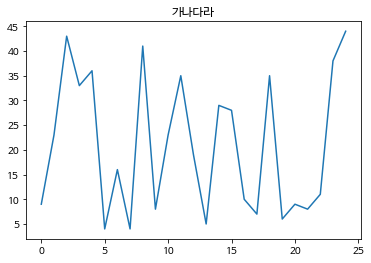

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 한글 지원 폰트
plt.rc('font', family='NanumBarunGothic')

# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False

plt.plot(np.random.randint(1, 50, 25))
plt.title("가나다라")
plt.show()

#### 앞으로 사용할 패키지 불러오기

In [ ]:
import re
import time
from glob import glob
from tqdm import tqdm
from packages import utils, tokenizer
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
from collections import defaultdict, Counter

import tensorflow as tf
import sentencepiece as spm
from transformers import TFBertForSequenceClassification, BertTokenizer
from transformers import TextClassificationPipeline

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

## 데이터 불러오기

In [ ]:
now_path = os.getcwd()
data_path = utils.recurrent_find_data_path(now_path)
bucket_files = utils.get_data_paths(data_path)
file_dict = utils.files_to_pd_dict(bucket_files)

100%|██████████| 18/18 [00:09<00:00,  1.92it/s]


TUNiB 데이터 : sample_answersheet, test, train  
AI_HUB 데이터 : 나머지 데이터

In [ ]:
keys = list(file_dict.keys())
print(f"불러온 데이터 파일명들 : {keys}")

불러온 데이터 파일명들 : ['sample_answersheet', 'test', 'train', '상수도_최종본(0416)', '여권 최종본(0416)', '교통_최종본(0416)', '차량등록_최종본(0429)', 'A 음식점(15,726)_new', 'B 의류(15,826)_new', 'C 학원(4,773)_new', 'E 생활서비스(11,087)_new', 'G 숙박업(7,113)_new', 'I 부동산(8,131)_new', 'H 관광여가오락(4,949)_new', 'D 소매점(14,949)_new', 'F 카페(7,859)_new']


In [ ]:
print(f'위협 문장 훈련 데이터 개수 : {file_dict["train"].shape[0]}')
print(f'위협 문장 테스트 데이터 개수 : {file_dict["test"].T.shape[0]}')
file_dict["train"].head()

위협 문장 훈련 데이터 개수 : 3950
위협 문장 테스트 데이터 개수 : 400


,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


AI_HUB 일반 대화 데이터 프레임 만들기

In [ ]:
normal_conversation = []
for name in keys[3:]:
  if "SENTENCE" in file_dict[name].columns:
    normal_conversation.append(file_dict[name]["SENTENCE"])
  elif "question" in file_dict[name].columns:
    normal_conversation.append(file_dict[name]["question"])
    normal_conversation.append(file_dict[name]["answer"])

In [ ]:
normal_pd = pd.DataFrame()
normal_pd["conversation"] = pd.concat(normal_conversation)
normal_pd["class"] = "일반 대화"
normal_pd = normal_pd.reset_index(drop=True)
normal_pd = normal_pd.reset_index()
normal_pd = normal_pd.rename(columns = {"index" : "idx"})

In [ ]:
print(f'일반 문장 훈련 데이터 개수 : {normal_pd.shape[0]}')
normal_pd.head()

일반 문장 훈련 데이터 개수 : 101497


,idx,conversation,class
0,0,수도 요금 이거 낼려고 그러는데요,일반 대화
1,1,아 수도 요금이요 제가 요금 확인 도와드릴텐데요 선생님 혹시 고지서 상에 관리번호 ...,일반 대화
2,2,선생님 고지서 상에 성함이 어떻게 되어 있습니까?,일반 대화
3,3,상수도 요금 못 냈는데 이게 가상계좌로 지금 못 넣잖아요 날짜가 지나면,일반 대화
4,4,혹시 관리번호 확인 가능할까요,일반 대화


AI_HUB 데이터와 TUNiB 데이터를 합친 데이터 프레임 만들기

In [ ]:
train = pd.concat([file_dict["train"], normal_pd]).reset_index(drop=True)
print(f'일반 문장 훈련 데이터 개수 : {train.shape[0]}')
train.head()

일반 문장 훈련 데이터 개수 : 105447


,idx,class,conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...


## 데이터 전처리

#### 결측데이터 제거

In [ ]:
print(f'결측 데이터 제거전 데이터 개수 : {train.shape[0]}')
train = utils.remove_nan(train).reset_index(drop=True)
print(f'결측 데이터 제거전 데이터 개수 : {train.shape[0]}')

결측 데이터 제거전 데이터 개수 : 105447
결측 데이터 제거전 데이터 개수 : 105338


#### 특수문자, 공백 제거

In [ ]:
def remove_punctuation(x):
  x = re.sub("[^ㄱ-ㅎ가-힣]+", " ", x)
  x = re.sub("[ ]+", " ", x)
  x = x.strip()
  return x

In [ ]:
train["pre_conversation"] = train["conversation"].apply(lambda x : remove_punctuation(x))
train.head()

,idx,class,conversation,pre_conversation
0,0,협박 대화,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,1,협박 대화,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,길동경찰서입니다 시 분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 얘기한...
2,2,기타 괴롭힘 대화,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,3,갈취 대화,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,4,갈취 대화,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...


#### Label Encoding

In [ ]:
bucket_class = []
label_names = ["협박 대화", "갈취 대화", "직장 내 괴롭힘 대화", 
               "기타 괴롭힘 대화", "일반 대화"]

for idx, label in enumerate(train["class"]):
  if label == label_names[0]:
    bucket_class.append(0)
  elif label == label_names[1]:
    bucket_class.append(1)
  elif label == label_names[2]:
    bucket_class.append(2)
  elif label == label_names[3]:
    bucket_class.append(3)
  elif label == label_names[4]:
    bucket_class.append(4)

train["class"] = bucket_class
train.head()

,idx,class,conversation,pre_conversation
0,0,0,지금 너 스스로를 죽여달라고 애원하는 것인가?\n 아닙니다. 죄송합니다.\n 죽을 ...,지금 너 스스로를 죽여달라고 애원하는 것인가 아닙니다 죄송합니다 죽을 거면 혼자 죽...
1,1,0,길동경찰서입니다.\n9시 40분 마트에 폭발물을 설치할거다.\n네?\n똑바로 들어 ...,길동경찰서입니다 시 분 마트에 폭발물을 설치할거다 네 똑바로 들어 한번만 더 얘기한...
2,2,3,너 되게 귀여운거 알지? 나보다 작은 남자는 첨봤어.\n그만해. 니들 놀리는거 재미...,너 되게 귀여운거 알지 나보다 작은 남자는 첨봤어 그만해 니들 놀리는거 재미없어 지...
3,3,1,어이 거기\n예??\n너 말이야 너. 이리 오라고\n무슨 일.\n너 옷 좋아보인다?...,어이 거기 예 너 말이야 너 이리 오라고 무슨 일 너 옷 좋아보인다 얘 돈 좀 있나...
4,4,1,저기요 혹시 날이 너무 뜨겁잖아요? 저희 회사에서 이 선크림 파는데 한 번 손등에 ...,저기요 혹시 날이 너무 뜨겁잖아요 저희 회사에서 이 선크림 파는데 한 번 손등에 발...


## 데이터 분석 및 시각화

협박 대화             896
갈취 대화             981
직장 내 괴롭힘 대화       979
기타 괴롭힘 대화        1094
일반 대화          101388
Name: idx, dtype: int64


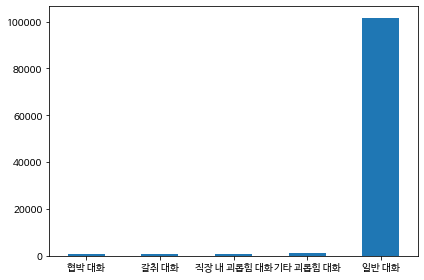

In [ ]:
group_count = train.groupby("class").count().iloc[:,0]
group_count.index = label_names
print(group_count)
group_count.plot(kind="bar")
plt.xticks(rotation = 360)
plt.tight_layout()
plt.show()

#### Under Sampling

In [ ]:
number_min_label = min(group_count)
print(f"레이블중에서 가장 개수가 작은 레이블의 개수 : {number_min_label}")

레이블중에서 가장 개수가 작은 레이블의 개수 : 896


In [ ]:
under_train = train.groupby("class").sample(number_min_label, random_state = 200)
under_train.groupby("class").count().iloc[:,0]

class
0    896
1    896
2    896
3    896
4    896
Name: idx, dtype: int64

#### 훈련셋 검증셋 나누기

In [ ]:
X = under_train["pre_conversation"].to_list()
Y = under_train["class"].to_list()

x_train, x_val_test, y_train, y_val_test = train_test_split(X, Y, 
                                                            test_size = 0.1, 
                                                            random_state = 200,
                                                            stratify = Y)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test,
                                                test_size = 0.5,
                                                random_state = 202,
                                                stratify = y_val_test)
print(f"x_train 개수 : {len(x_train)}")
print(f"y_train 개수 : {len(y_train)}")
print(f"x_val 개수 : {len(x_val)}")
print(f"y_val 개수 : {len(y_val)}")
print(f"x_test 개수 : {len(x_test)}")
print(f"y_test 개수 : {len(y_test)}")

print(f"훈련 데이터 레이블 비율 확인 : {Counter(y_train)}")
print(f"검증 데이터 레이블 비율 확인 : {Counter(y_val)}")
print(f"테스트 데이터 레이블 비율 확인 : {Counter(y_test)}")

x_train 개수 : 4032
y_train 개수 : 4032
x_val 개수 : 224
y_val 개수 : 224
x_test 개수 : 224
y_test 개수 : 224
훈련 데이터 레이블 비율 확인 : Counter({3: 807, 4: 807, 1: 806, 0: 806, 2: 806})
검증 데이터 레이블 비율 확인 : Counter({0: 45, 2: 45, 3: 45, 1: 45, 4: 44})
테스트 데이터 레이블 비율 확인 : Counter({2: 45, 1: 45, 4: 45, 0: 45, 3: 44})


## HuggingFace 적용하기

#### Tokenizing

In [ ]:
HUGGINGFACE_MODEL_PATH = "klue/bert-base"
# Load Tokenizer
tokenizer = BertTokenizer.from_pretrained(HUGGINGFACE_MODEL_PATH)

Downloading:   0%|          | 0.00/243k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/125 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/289 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/425 [00:00<?, ?B/s]

In [ ]:
# Tokenizing
train_encodings = tokenizer(x_train, truncation=True, padding=True)
val_encodings = tokenizer(x_val, truncation=True, padding=True)

for key in train_encodings:
  print(f"{key} : {train_encodings[key][0]}")

input_ids : [2, 3767, 6304, 7026, 2200, 1453, 2998, 1460, 3626, 2067, 2321, 4442, 4267, 2031, 2073, 4030, 1389, 2031, 2470, 2201, 2119, 6702, 1451, 2069, 1233, 5675, 2088, 1889, 17598, 4229, 2507, 2242, 1545, 2116, 4177, 1451, 2069, 1511, 2778, 4177, 5468, 2052, 2170, 2182, 3767, 2031, 2073, 3767, 2723, 2318, 22547, 2118, 636, 10224, 2073, 3822, 2144, 2200, 732, 568, 2062, 13932, 2182, 8021, 2020, 2266, 2200, 6462, 1122, 2073, 1451, 2052, 2241, 1041, 2052, 2170, 2182, 1507, 2069, 5629, 2205, 2318, 4577, 2203, 19145, 678, 5340, 2088, 1335, 2051, 17879, 28468, 1545, 2116, 3944, 7619, 2259, 1451, 2179, 2147, 3686, 2154, 1169, 2223, 2067, 2460, 1378, 2651, 6301, 5723, 4292, 18265, 1351, 2062, 636, 1451, 4217, 1038, 2252, 17852, 2998, 4122, 2470, 2201, 5703, 2085, 7187, 4954, 2154, 2182, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

#### Tensorflow dataset으로 변환

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), 
                                                    y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((dict(val_encodings), 
                                                  y_val))
train_dataset

<TensorSliceDataset shapes: ({input_ids: (427,), token_type_ids: (427,), attention_mask: (427,)}, ()), types: ({input_ids: tf.int32, token_type_ids: tf.int32, attention_mask: tf.int32}, tf.int32)>

#### Fine-tuning BERT

In [ ]:
num_labels = max(train["class"]) + 1
model = TFBertForSequenceClassification.from_pretrained(HUGGINGFACE_MODEL_PATH, 
                                                        num_labels=num_labels, 
                                                        from_pt=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, 
              loss=model.compute_loss, 
              metrics=['accuracy'])
model.summary()

Downloading:   0%|          | 0.00/424M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForSequenceClassification: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  110617344 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  3845      
                                                                 
Total params: 110,621,189
Trainable params: 110,621,189
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

callback_earlystop = EarlyStopping(
    monitor="val_accuracy", 
    min_delta=0.001, # the threshold that triggers the termination (acc should at least improve 0.001)
    patience=2)

model.fit(
    train_dataset.shuffle(1000).batch(16), epochs=1, batch_size=16,
    validation_data=val_dataset.shuffle(1000).batch(16),
    callbacks = [callback_earlystop]
)

252/252 [==============================] - 242s 888ms/step - loss: 0.4178 - accuracy: 0.8562 - val_loss: 0.2582 - val_accuracy: 0.9152


#### 모델 저장하기

In [ ]:
model_path = "./model/fine-tuned-klue-bert-base-2"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('./model/fine-tuned-klue-bert-base-2/tokenizer_config.json',
 './model/fine-tuned-klue-bert-base-2/special_tokens_map.json',
 './model/fine-tuned-klue-bert-base-2/vocab.txt',
 './model/fine-tuned-klue-bert-base-2/added_tokens.json')

## HuggingFace 모델 평가하기

In [ ]:
# Load Fine-tuning model
model_path = "./model/fine-tuned-klue-bert-base-2"
loaded_tokenizer = BertTokenizer.from_pretrained(model_path)
loaded_model = TFBertForSequenceClassification.from_pretrained(model_path)

text_classifier = TextClassificationPipeline(
    tokenizer=loaded_tokenizer, 
    model=loaded_model, 
    framework='tf',
    return_all_scores=True
)

Some layers from the model checkpoint at ./model/fine-tuned-klue-bert-base-2 were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at ./model/fine-tuned-klue-bert-base-2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [ ]:
predicted_label_list = []
predicted_score_list = []

for text in tqdm(x_test):
    # predict
    preds_list = text_classifier(text)[0]

    sorted_preds_list = max(preds_list, key=lambda x: x['score'])
    predicted_label_list.append(sorted_preds_list["label"]) # label
    predicted_score_list.append(sorted_preds_list["score"]) # score

100%|██████████| 224/224 [01:36<00:00,  2.32it/s]


In [ ]:
y_pred = [int(label[-1]) for label in predicted_label_list]
y_true = y_test
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.93      0.91        45
           1       0.85      0.98      0.91        45
           2       0.98      0.89      0.93        45
           3       0.85      0.75      0.80        44
           4       1.00      1.00      1.00        45

    accuracy                           0.91       224
   macro avg       0.91      0.91      0.91       224
weighted avg       0.91      0.91      0.91       224



## 사후 평가

In [ ]:
false_list = []
for i in range(len(y_true)):
  if y_true[i] != y_pred[i]:
    false_list.append(i)

In [ ]:
test_dataset = pd.DataFrame({"x" : x_test, "y_true" : y_test, "y_pred" : y_pred})
test_dataset.iloc[false_list, :]

,x,y_true,y_pred
53,이자는 이자까지 줬잖아 그건 저번 기간 이자고 이번 기간 이자까지 줘야지 이 년아 ...,3,0
58,야 니 롤 티어 첼린저더라 응 맞아 나 요즘 롤 즐겨하는데 티어가 안오르던데 너 좀...,0,3
69,내가 말하는게 우습냐 미미안해 우습냐고 새끼야 내가 뭘 잘못했는지 모르겠어 미안해 ...,0,3
83,아니 피뽑는게 왜이렇게아파 환자분 원래조끔 따금해요 바늘이 들어가는데 안아플수가없잖...,3,0
115,야 체육복 있냐 응 응응 있지 왜 나 교시에 체육시간인데 체육복 없어서 빌려주라 아...,3,1
119,야야 너 기절놀이아냐 그게뭔데 궁금하지 이리와봐 알려줄께 이렇게 목 조르면 기절한다...,3,0
127,야 거지 너네집 저기 판자촌이라면서 판자촌이 뭐야 왜 저 위에 다 쓰러져가는 집들 ...,3,1
136,야 저새끼 뭐냐 이야 일병이 슬리퍼를 신고 담밸 피러 쳐왔네 죄송합니다 시간이 없어...,2,3
141,김씨 저번에 빌려간 돈 이자가 오백만원이야 아니 원금이 만원인데 어떻게 이자가 일 ...,1,0
142,야 너 내가 카톡하면 초 안에 보라고 했지 아 어 미안 근데 왜이렇게 늦어 정말 맞...,3,1


#### Confusion Matrix

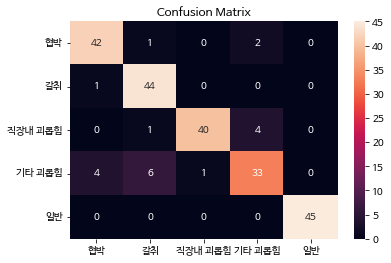

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)
names = ["협박", "갈취", "직장내 괴롭힘", "기타 괴롭힘", "일반"]
conf_matrix = pd.DataFrame(conf_matrix, index = names, columns = names)
sns.heatmap(conf_matrix, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
conf_matrix.style.background_gradient(cmap = "summer")

,협박,갈취,직장내 괴롭힘,기타 괴롭힘,일반
협박,42,1,0,2,0
갈취,1,44,0,0,0
직장내 괴롭힘,0,1,40,4,0
기타 괴롭힘,4,6,1,33,0
일반,0,0,0,0,45
